# 지원동기 대신 써주는 프로그램

In [1]:
from bs4 import BeautifulSoup
from downloads import *
import requests
import time
import urllib
import os
from nltk.probability import FreqDist
from NLP import * 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
import re
import matplotlib.font_manager as fm
import ngram
from konlpy.tag import Hannanum, Kkma, Komoran, Okt #, Mecab (Linux)
font_setting()

# Input

In [2]:
q = input("지원하시는 회사의 이름을 기재해주세요\t")
q2 = input("지원하는 회사의 직무를 기재해주세요\t")
try:
    p = int(input("몇 페이지까지 검색할까요?\t\t"))
except:
    p = 100
# q3=input("공고에 직무에 대한 설명이 있다면 키워드 중심으로 같이 써주세요(없을 시 공란으로 두세요)\t")

지원하시는 회사의 이름을 기재해주세요	비씨카드
지원하는 회사의 직무를 기재해주세요	IT
몇 페이지까지 검색할까요?		


In [3]:
number = re.compile("\d")

In [4]:
def cleaning_query(query):
    naver = BeautifulSoup(download("https://search.naver.com/search.naver?",params={"query":query}).text,"lxml")
    company_official_name = naver.select_one(".sp_company .main_title").text
    company_name = [_.text for _ in naver.select(".nsite dt a")][0]
    company_link = [_.text for _ in naver.select(".nsite dt a")][1].replace("www.","").replace(".com","")
    company_details = [_.text.strip() for _ in naver.select(".company_area .txt,.company_area .txt_info") if not number.search(_.text)]
    company_stock_name = company_details[0]
    company_subsidary = company_details[1].split(" ")[0]
    company_ceo = company_details[2]
    company_industry = company_details[3]
    query_list = [query, q2]
    query_list += [company_official_name,company_name,*split_sub(company_official_name),
               *split_sub(company_name),company_stock_name,company_subsidary]

    ub = re.compile("업")
    query_list.extend(ub.sub("",company_industry).split())
    for _ in range(2,len(q)):
        query_list += ngram.umjeol(query,_)
        query_list += ngram.umjeol(company_ceo,_)
    query_list=[_.lower() for _ in query_list]
    query_list = [_ for _ in unique(query_list) if _.strip() != "" and "," not in _] 
    return query_list, 

In [5]:
def split_sub(name):
    pttn=re.compile("[A-z]+")
    if pttn.search(name):
        return pttn.findall(name)[0],pttn.sub("",name)
    else:
        return ''

In [6]:
naver = BeautifulSoup(download("https://search.naver.com/search.naver?",params={"query":q}).text,"lxml")
company_official_name = naver.select_one(".sp_company .main_title").text
company_name = [_.text for _ in naver.select(".nsite dt a")][0]
company_link = [_.text for _ in naver.select(".nsite dt a")][1].replace("www.","").replace(".com","")
company_details = [_.text.strip() for _ in naver.select(".company_area .txt,.company_area .txt_info") if not number.search(_.text)]
company_stock_name = company_details[0]
company_subsidary = company_details[1].split(" ")[0]
company_ceo = company_details[2]
company_industry = company_details[3]

query_list = [q, q2]
query_list += [company_official_name,company_name,*split_sub(company_official_name),
               *split_sub(company_name),company_stock_name,company_subsidary]
query_list = [_ for _ in unique(query_list) if _.strip() != ""] 

In [7]:
company_friends = [_.text.strip() for _ in naver.select("._related_keyword_ul a") 
                   if BeautifulSoup(download("https://search.naver.com/search.naver"+_["href"]).text,"lxml")
                       .select(".company_area .txt,.company_area .txt_info") and len(_.text.split())==1]

In [8]:
company_friends

['bc카드', '신한카드', '삼성카드', '롯데카드', '국민카드', '현대카드', '하나카드', '우리카드', 'kb국민카드']

In [9]:
company_official_name

'비씨카드'

In [10]:
print("{0}에 입사하게 된다면 최고의 {1} 전문가가 되도록 언제나 노력하겠습니다".format(company_official_name,q2))

비씨카드에 입사하게 된다면 최고의 IT 전문가가 되도록 언제나 노력하겠습니다


# Crawling

In [11]:
def clean_title(title,query):
    for q in query:
        if q in title:
            title = title.replace(q,"")
    pattern = re.compile("\[.*\]")
    if pattern.search(title):
        title = pattern.sub("",title)
    return title

## keyword cleansing : 그룹사, 다른이름 빼기

In [12]:
query_list

['BC', 'BC카드', 'IT', '비씨카드', '비씨카드(주)', '카드', '케이티']

In [13]:
ub = re.compile("업")

In [14]:
query_list.extend(ub.sub("",company_industry).split())

In [15]:
for _ in range(2,len(q)):
    query_list += ngram.umjeol(q,_)
    query_list += ngram.umjeol(company_ceo,_)

In [16]:
query_list=[_.lower() for _ in query_list]

In [17]:
query_list=[_ for q in query_list for _ in q.split(" ")]

In [18]:
news_list=[]
for page in range(1,p+1):
    url=download("https://search.daum.net/search",params={"w":"news","q":q+" "+q2,"cluster":"y","p":str(page)})
    dom=BeautifulSoup(url.text,"lxml")
    news_list+=[clean_title(_.text,query_list) for _ in dom.select("article .wrap_tit.mg_tit a")]

In [19]:
pd.DataFrame(news_list).to_csv(str(p)+str(q)+".csv")

## find keyword  : preprocessing

In [20]:
find_keyword=[_.upper().strip() for _ in news_list if _.strip() != ""]

In [21]:
pattern=re.compile("^NN|(SL)")

In [22]:
okt = Komoran()

In [23]:
freq=FreqDist([_ for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list and pattern.search(_[1])])

In [24]:
freq

FreqDist({('KT', 'SL'): 345, ('세상', 'NNG'): 153, ('기업', 'NNG'): 152, ('국민', 'NNG'): 138, ('황창규', 'NNP'): 123, ('회장', 'NNG'): 118, ('G', 'SL'): 67, ('시스템', 'NNG'): 64, ('LG CNS', 'NNP'): 63, ('그룹', 'NNP'): 53, ...})

In [25]:
freq=FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) if _[0].lower() not in query_list and len(_[0])>1 and pattern.search(_[1])])

# 시각화

In [26]:
plt.rcParams.update({'font.size': 10, 'figure.figsize':(14,12)})

In [27]:
# !pip install wordcloud

In [28]:
from wordcloud import WordCloud

In [29]:
for_cld = FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) if pattern.search(_[1]) and _[0] not in query_list and len(_[0])>1])
# for_cld = FreqDist([_[0] for _ in freq])

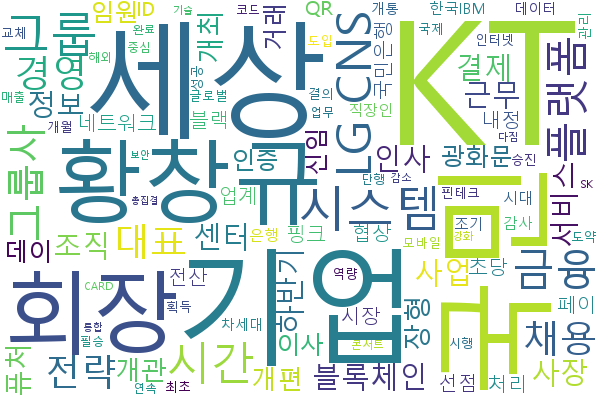

In [30]:
cld = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",width=600,height=400,background_color='white',max_words=100)
cld.generate_from_frequencies(freq).to_image()

## 동종회사

In [61]:
company_friends

['bc카드', '신한카드', '삼성카드', '롯데카드', '국민카드', '현대카드', '하나카드', '우리카드', 'kb국민카드']

In [62]:
friends_news_list = []
for comp in company_friends: 
    news = []
    for page in range(1,p+1):
        url = download("https://search.daum.net/search",params={"w":"news","q":comp+" "+q2,"cluster":"y","p":str(page)})
        dom = BeautifulSoup(url.text,"lxml")
        news += [clean_title(_.text,query_list) for _ in dom.select("article .wrap_tit.mg_tit a")]
    friends_news_list += [news]

ConnectionError: HTTPSConnectionPool(host='search.daum.net', port=443): Max retries exceeded with url: /search?w=news&q=%EC%82%BC%EC%84%B1%EC%B9%B4%EB%93%9C+IT&cluster=y&p=9 (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000001CF41B98940>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed',))

In [ ]:
def cleansing(list_1d, query_list):
    find_keyword = [_.upper().strip() for _ in list_1d  if _.strip() != ""]
    freq = FreqDist([_ for keyword in find_keyword for _ in okt.pos(keyword) if _[0] not in query_list and pattern.search(_[1])])
    freq = FreqDist([_[0] for keyword in find_keyword for _ in okt.pos(keyword) 
                           if _[0] not in query_list and len(_[0])>1 and pattern.search(_[1])])
    return freq

In [ ]:
name_w_friends = [q]+company_friends
news_w_friends = [news_list] + friends_news_list

In [35]:
zipper = list(zip(name_w_frines, news_w_friends))

In [36]:
cleaning_query("카카오")

[' 조',
 ' 조수',
 '(주)카카오',
 'it',
 'kakao',
 '기타',
 '민수',
 '및',
 '서비스',
 '수용',
 '여민',
 '여민수',
 '인터넷',
 '정보매개',
 '조수',
 '조수용',
 '카오',
 '카카',
 '카카오',
 '코스피',
 '포털']

In [37]:
cleansing(zipper[0][1],zipper[0][0]),

(FreqDist({'KT': 349, '세상': 153, '기업': 152, '국민': 143, '황창규': 123, '회장': 119, '시스템': 64, 'LG CNS': 63, '그룹': 63, '시간': 56, ...}),)

In [38]:
freq_list = []
for name, news in zipper:
    freq_list.append(cleansing(news,name))

In [39]:
freq_w_friends = [freq] + freq_list

In [40]:
def lfd():
    return defaultdict(float)

def ld():
    return defaultdict(int)

In [41]:
from math import log2

In [42]:
tf = defaultdict(lfd)
df = defaultdict(int)
N = len(freq_w_friends)
maxtf = defaultdict(int)
i = 0 
for document in freq_w_friends:
    maxtf[i] = max(document.values())
    for term, freq in document.items():
        tf[i][term] = (freq) / maxtf[i] 
        df[term] += 1
    i += 1
idf = {term:(1+log2(N/freq)) for term, freq in df.items()}

In [43]:
tfidf = defaultdict(ld)
i = 0 
for document in freq_w_friends:
    for term, freq in document.items():
        tfidf[i][term] = tf[i][term] * idf[term]
    i += 1

In [44]:
tfidf.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

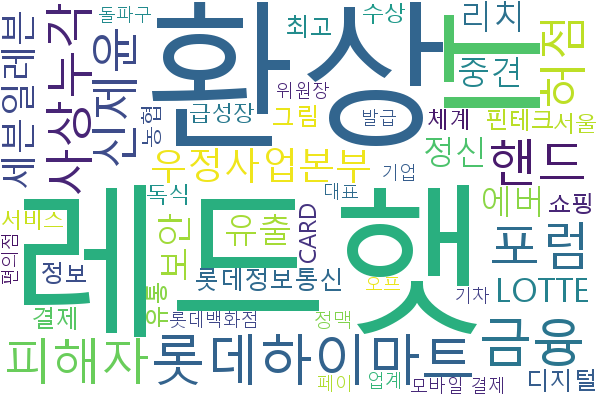

In [58]:
cld = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf",width=600,height=400,background_color='white',max_words=50)
cld.generate_from_frequencies(tfidf[5]).to_image()

In [48]:
okt.pos("플랫폼")

[('플랫폼', 'NNP')]

In [49]:
okt.pos("황창규")

[('황창규', 'NNP')]

In [60]:
name_w_friends[6]

'현대카드'

In [54]:
tfidf[3]

defaultdict(int,
            {'대형': 0.04250771704768827,
             '역사': 0.027907467164234378,
             '개발': 0.10679611650485436,
             'AXE': 0.043295452608129094,
             '김동호': 0.043295452608129094,
             '가속': 0.08501543409537654,
             '새해': 0.014169239015896088,
             '결산': 0.03358671474405143,
             'JOBS': 0.043295452608129094,
             '체제': 0.0331311705946583,
             '기업': 0.27184466019417475,
             'KOSCOM': 0.043295452608129094,
             '핀테크': 0.1650485436893204,
             '보배': 0.03358671474405143,
             '공동': 0.1275231511430648,
             '연계': 0.12451476837378263,
             'BUSINESS': 0.03358671474405143,
             'KCC': 0.03358671474405143,
             '종합': 0.05521861765776384,
             '텃밭': 0.03358671474405143,
             '국지': 0.020752461395630438,
             'COMPETE': 0.027907467164234378,
             '막바지': 0.01603957957844362,
             '제값': 1.125681767811356